In [5]:
import os
import logging
import tqdm
import torch
import sys
import numpy as np
sys.path.append("../../")
from CKA import cka
from openpoints.utils import EasyConfig, cal_model_parm_nums, load_checkpoint, set_random_seed
from openpoints.models import build_model_from_cfg
from openpoints.dataset import build_dataloader_from_cfg, get_scene_seg_features

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

cfg = EasyConfig()
cfg_path = '../../cfgs/s3dis/pointnext-l.yaml'
cfg.load(cfg_path, recursive=True)
cfg.seed = 1
cfg.pretrained_path = "/media/disk1/lhj/pointcloud/logs_exps/logs_pointnext/s3dis/s3dis-train-pointnext-l-ngpus1-seed2588-20220822-140323-YxtPD49NpuraRJ4kajD869/checkpoint/s3dis-train-pointnext-l-ngpus1-seed2588-20220822-140323-YxtPD49NpuraRJ4kajD869_ckpt_best.pth"
cfg.batch_size = 32
cfg.val_batch_size = 1
cfg.rank = 0
cfg.distributed = False

set_random_seed(cfg.seed)

In [6]:
# @torch.no_grad()
# def get_features(model, data_loader, cfg):
#     model.eval()  # set model to eval mode
#     data = next(iter(data_loader))
#     keys = data.keys() if callable(data.keys) else data.keys
#     for key in keys:
#         data[key] = data[key].cuda(non_blocking=True)
#     target = data['y'].squeeze(-1)
#     if len(data['x'].shape) > 2:
#         data['x'] = data['x'].transpose(1, 2)
#     data['x'] = get_scene_seg_features(cfg.model.in_channels, data['pos'], data['x'])
#     # logits = model(data)
#     features = model.encoder.forward_all_features(data)
#     return features 

In [7]:
## build model
if cfg.model.get('in_channels', None) is None:
    cfg.model.in_channels = cfg.model.encoder_args.in_channels
model = build_model_from_cfg(cfg.model).to(cfg.rank)
model_size = cal_model_parm_nums(model)
logging.info(model)
logging.info('Number of params: %.4f M' % (model_size / 1e6))

## build dataset
train_loader = build_dataloader_from_cfg(cfg.batch_size,
                                         cfg.dataset,
                                         cfg.dataloader,
                                         datatransforms_cfg=cfg.datatransforms,
                                         split='train',
                                         distributed=cfg.distributed,
                                         )
# val_loader = build_dataloader_from_cfg(cfg.get('val_batch_size', cfg.batch_size),
#                                         cfg.dataset,
#                                         cfg.dataloader,
#                                         datatransforms_cfg=cfg.datatransforms,
#                                         split='val',
#                                         distributed=cfg.distributed
#                                         )
data_loader = train_loader
logging.info(f"length of validation dataset: {len(data_loader.dataset)}")
num_classes = data_loader.dataset.num_classes if hasattr(data_loader.dataset, 'num_classes') else None
if num_classes is not None:
    assert cfg.num_classes == num_classes
logging.info(f"number of classes of the dataset: {num_classes}")
cfg.classes = data_loader.dataset.classes if hasattr(data_loader.dataset, 'classes') else np.range(num_classes)
cfg.cmap = np.array(data_loader.dataset.cmap) if hasattr(data_loader.dataset, 'cmap') else None

best_epoch, best_val = load_checkpoint(model, pretrained_path=cfg.pretrained_path)
# features = get_features(model, data_loader, cfg)

[32, 32, 13] norm: bn {'act': 'relu'}


In [8]:
## extract features
model.eval()  # set model to eval mode
data = next(iter(data_loader))
keys = data.keys() if callable(data.keys) else data.keys
for key in keys:
    data[key] = data[key].cuda(non_blocking=True)
target = data['y'].squeeze(-1)
if len(data['x'].shape) > 2:
    data['x'] = data['x'].transpose(1, 2)
data['x'] = get_scene_seg_features(cfg.model.in_channels, data['pos'], data['x'])
_ , features = model.encoder.forward_all_features(data); features = features[1:]
# _ , features = model.encoder.forward_all_block_features(data)


RuntimeError: CUDA out of memory. Tried to allocate 750.00 MiB (GPU 0; 39.45 GiB total capacity; 22.09 GiB already allocated; 391.31 MiB free; 22.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(data['x'].shape)

torch.Size([32, 4, 24000])


In [ ]:
len(features)

15

In [ ]:
features[1].shape

torch.Size([32, 64, 6000])

In [ ]:
data['x'].size()[0]

32

In [ ]:
## compute similar matrix
n = data['x'].size()[0]
for i in range(len(features)):
    features[i] = features[i].view(n, -1)
    features[i] = features[i].data.cpu().numpy()
similar_matrix = np.zeros((len(features), len(features)))
for i in range(len(features)):
    for j in range(len(features)):
        with torch.no_grad():
            similar_matrix[i][j] = cka.cka(cka.gram_linear(features[i]), cka.gram_linear(features[j])) 

In [ ]:
features[0].shape

(32, 768000)

In [ ]:
similar_matrix

array([[1.        , 0.9631139 , 0.72157317, 0.69516444, 0.67457247,
        0.66918164, 0.66561192, 0.66108084, 0.66068947, 0.662233  ,
        0.65929544, 0.6579234 , 0.64411592, 0.6510371 , 0.64863747],
       [0.9631139 , 1.        , 0.86520445, 0.84420699, 0.82819873,
        0.82420838, 0.8205207 , 0.81597227, 0.81562275, 0.81626433,
        0.81374949, 0.8131128 , 0.79865116, 0.80623996, 0.80096167],
       [0.72157317, 0.86520445, 0.99999988, 0.99665278, 0.99340874,
        0.99154031, 0.98894519, 0.98631388, 0.9848935 , 0.98234701,
        0.98056018, 0.97960502, 0.96334547, 0.96986592, 0.96189165],
       [0.69516444, 0.84420699, 0.99665278, 1.        , 0.9964481 ,
        0.99656355, 0.99527258, 0.99332726, 0.99282128, 0.98902369,
        0.98826909, 0.98833454, 0.96974021, 0.97631633, 0.96717703],
       [0.67457247, 0.82819873, 0.99340874, 0.9964481 , 0.99999994,
        0.99633819, 0.99421376, 0.99131727, 0.9893775 , 0.98815501,
        0.98681712, 0.98595232, 0.97304988, 

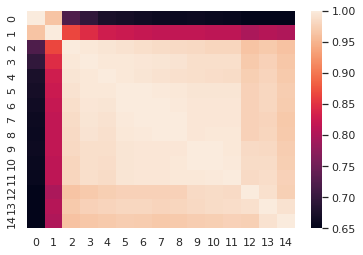

In [ ]:
import numpy as np
np.random.seed(0)
import seaborn as sns
sns.set_theme()
ax = sns.heatmap(similar_matrix, vmax=1.0, vmin=0.65)
